# 사용자 기반 협업 필터링 추천시스템

In [54]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sqlalchemy import create_engine

import pymysql
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random

In [2]:
user = 'root'
pwd = '1234'
server = 'localhost'
db_name = 'movie_review'
engine = create_engine(f'mysql+pymysql://{user}:{pwd}@{server}/{db_name}?charset=utf8', 
              convert_unicode = True)

connect = engine.connect()
raw_data = pd.read_sql_table('raw_file', connect)
raw_data

,id,user,title,genre,score
0,63,tnen,기방도령,코미디,4
1,64,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,65,tnen,사바하,미스터리,10
3,66,tnen,글래스,드라마,10
4,67,tnen,모털 엔진,액션,10
...,...,...,...,...,...
35689,35752,dela,나이브스 아웃,미스터리,10
35690,35753,dela,헌트,액션,9
35691,35754,dela,미드소마,공포,5
35692,35755,dela,미져리,스릴러,10


In [3]:
%%time
# 10개 평가 이하 영화 제거

def refinding_df(raw_data):
    title_number_df = raw_data.groupby('title').count().sort_values('user')
#     print(title_number_df)
    title_under_10 = title_number_df[title_number_df.user <= 10]
#     print(title_under_10)
    
    title_under_10_list = list(title_under_10.index)
#     print(title_under_10_list)
    for title in title_under_10_list:
        raw_data = raw_data[raw_data['title'] != title]
    return raw_data
    
raw_df = refinding_df(raw_data)
raw_df

Wall time: 24.6 s


,id,user,title,genre,score
0,63,tnen,기방도령,코미디,4
1,64,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,65,tnen,사바하,미스터리,10
3,66,tnen,글래스,드라마,10
4,67,tnen,모털 엔진,액션,10
...,...,...,...,...,...
35685,35748,dela,마스터,드라마,6
35689,35752,dela,나이브스 아웃,미스터리,10
35690,35753,dela,헌트,액션,9
35691,35754,dela,미드소마,공포,5


In [4]:
raw_df.tail()

,id,user,title,genre,score
35685,35748,dela,마스터,드라마,6
35689,35752,dela,나이브스 아웃,미스터리,10
35690,35753,dela,헌트,액션,9
35691,35754,dela,미드소마,공포,5
35693,35756,dela,살인마 잭의 집,드라마,6


In [5]:
df = raw_df.copy()
df

,id,user,title,genre,score
0,63,tnen,기방도령,코미디,4
1,64,tnen,페이트 스테이 나이트 헤븐즈필 제2장 로스트 버터플라이,애니메이션,1
2,65,tnen,사바하,미스터리,10
3,66,tnen,글래스,드라마,10
4,67,tnen,모털 엔진,액션,10
...,...,...,...,...,...
35685,35748,dela,마스터,드라마,6
35689,35752,dela,나이브스 아웃,미스터리,10
35690,35753,dela,헌트,액션,9
35691,35754,dela,미드소마,공포,5


In [6]:
df = df.drop(['id'],axis = 1)
df.tail()

,user,title,genre,score
35685,dela,마스터,드라마,6
35689,dela,나이브스 아웃,미스터리,10
35690,dela,헌트,액션,9
35691,dela,미드소마,공포,5
35693,dela,살인마 잭의 집,드라마,6


## DATA 탐색

In [7]:
user_num = df['user'].unique().shape[0]
movie_num = df.title.unique().shape[0]

print(f'유저에 수는 {user_num}명이고, \n영화의 수는 {movie_num}이다.')

유저에 수는 813명이고, 
영화의 수는 676이다.


## 평점을 많이 남긴 유저 탑10

In [8]:
user_top_10 = df.user.value_counts()[:10]
user_top_10

ykki    485
yang    264
choi    240
phs3    225
mari    221
bell    201
psgi    195
pass    186
inos    183
llfo    180
Name: user, dtype: int64

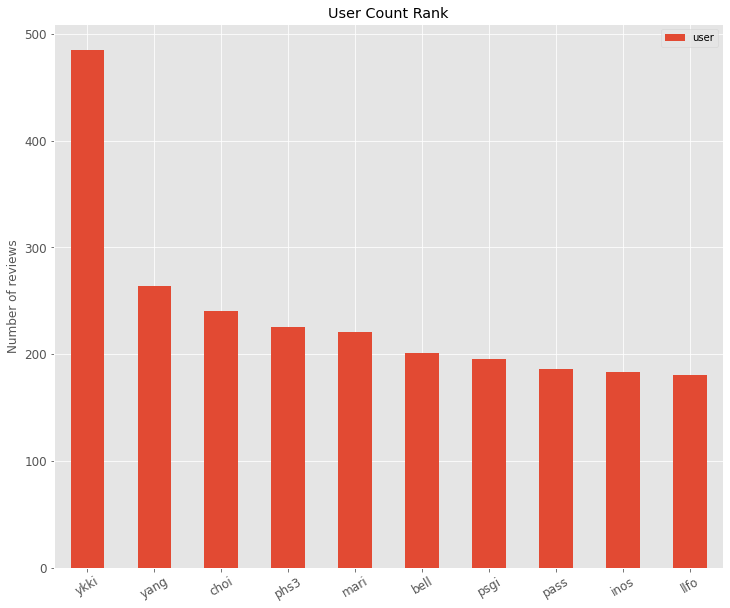

In [9]:
plt.style.use('ggplot')
plt.figure(figsize=(12,10))
user_top_10.plot(kind='bar', title='User Count Rank', legend=True, 
                 fontsize=12)
plt.xticks(rotation=30)
plt.ylabel('Number of reviews', fontsize=12)
plt.show()

## 유저들로 부터 평점을 많이 받은 영화 탑10

In [10]:
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
# font_name
rc('font', family=font_name)
movie_top_10 = df.title.value_counts()[:10]

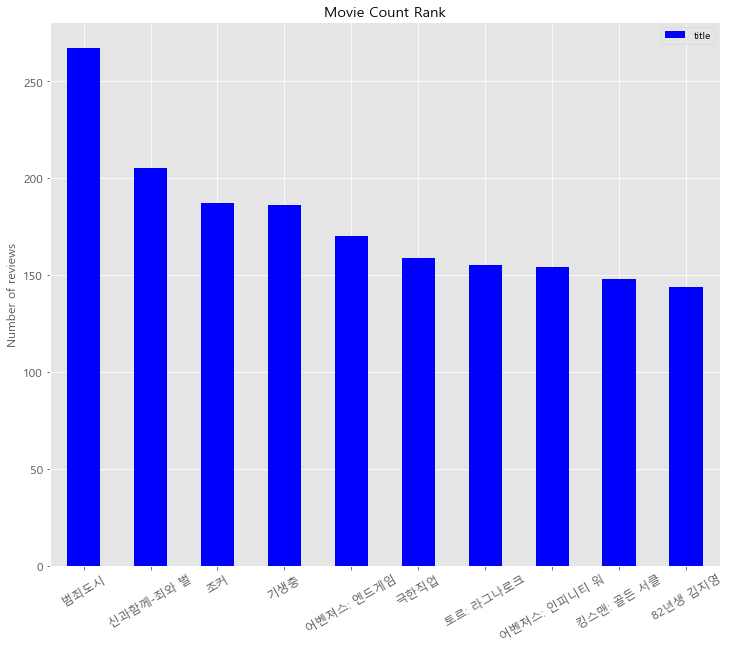

In [11]:
plt.figure(figsize=(12,10))
movie_top_10.plot(kind='bar', title='Movie Count Rank', legend=True, 
                 fontsize=12, color='b')

plt.xticks(rotation=30)
plt.ylabel('Number of reviews', fontsize=12)
plt.show()

## 평점랭킹

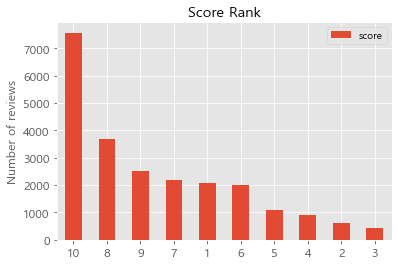

In [12]:
score_ranking = df.score.value_counts()
plt.style.use('ggplot')
score_ranking.plot(kind='bar', title='Score Rank', legend=True, fontsize=12)
plt.xticks(rotation=0)
plt.ylabel('Number of reviews', fontsize=12)
plt.show()

##  Colaborative Filtering
#### 1. 행렬로 만든다.
#### 2. 추천하고자 하는 유저가 입력되면 코사인 유사도를 이용하여 각 유사도를 구한다.
#### 3. 추천하고자 하는 유저(t)와 K명의 비슷한 유저들의 아이템에 대한 평점을 이용하여  유저가아직 평가하지 않은 영화의 평점을 예측해서 유저에게 추천함.
#### 4. Validation 한다.

In [13]:
#LabelEncoder를 이용하여 수치화
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df.copy()
    labeling_data = Lec.fit_transform(df_copy[column_name].values)
    df_label = pd.DataFrame(labeling_data, columns = [column_name+'_label'], index=df_copy.index)
#     print(labeling_data)
    return df_label
    
df_user = execute_labeling('user')
df_title = execute_labeling('title')

In [14]:
df_user.tail(2)

,user_label
35691,143
35693,143


In [15]:
df_title.tail(2)

,title_label
35691,254
35693,336


In [16]:
df_copy = df.copy()
df_copy = df_copy.drop(df_copy.columns[[0]],axis=1)
df_label = pd.concat([df_user, df_title, df_copy], axis=1)
df_label.tail()

,user_label,title_label,title,genre,score
35685,143,214,마스터,드라마,6
35689,143,101,나이브스 아웃,미스터리,10
35690,143,658,헌트,액션,9
35691,143,254,미드소마,공포,5
35693,143,336,살인마 잭의 집,드라마,6


In [17]:
df_label.shape

(23095, 5)

In [18]:
movie_list = list(df['title'].unique())

movie_list = sorted(movie_list, key=str)
movie_list
df_matrix = pd.DataFrame(columns = ['user'] + movie_list)
df_matrix

,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,21 브릿지: 테러 셧다운,23 아이덴티티,...,화차,황해,후궁 : 제왕의 첩,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히트,히트맨,"힘을 내요, 미스터 리"


In [22]:
user_num = len(df_label['user_label'].unique())
movie_num = len(df_label['title_label'].unique())

user_score_list = []
for num in tqdm(range(0, user_num)):
    user_score_list = [0 for i in range(movie_num)]
#     print(user_score_list)
    
    df_tmp = df_label[df_label['user_label'] == num]
# df_tmp
    for j in df_tmp.index:
        user_score_list[df_tmp.loc[j]['title_label']-1] = df_tmp.loc[j]['score'] # 순번이라 -1
# user_score_list        
    df_matrix.loc[num] = [num] + user_score_list
    
df_matrix
    

100%|████████████████████████████████████████████████████████████████████████████████| 813/813 [00:25<00:00, 32.39it/s]


,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,21 브릿지: 테러 셧다운,23 아이덴티티,...,화차,황해,후궁 : 제왕의 첩,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히트,히트맨,"힘을 내요, 미스터 리"
0,0,0,8,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,6,0,8
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,808,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
809,809,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
810,810,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
811,811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
type(df_matrix)

pandas.core.frame.DataFrame

##### pickle를 사용해 데이터 프레임을 바이너리로 바꿈(유틸리티 행렬)

In [24]:
import pickle

file = df_matrix
directory = open('utilitymatrix', 'wb')
pickle.dump(file, directory)
directory.close()

In [25]:
user_name = list(df['user'].unique())
user_name = sorted(user_name, key=str)
user_name = pd.DataFrame(user_name)
user_name.columns = ['user_name']
file_user = user_name

directory_user = open('user_name', 'wb')
pickle.dump(file_user, directory_user)
directory_user.close()

##### 저장한 파일 불러오기

In [26]:
f = open('utilitymatrix', 'rb',)
utilitymatrix = pickle.load(f)
df = utilitymatrix
df.tail(2)

,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,21 브릿지: 테러 셧다운,23 아이덴티티,...,화차,황해,후궁 : 제왕의 첩,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히트,히트맨,"힘을 내요, 미스터 리"
811,811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
812,812,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
f = open('user_name', 'rb',)
user_name = pickle.load(f)
user_name.tail(2)

,user_name
811,zzza
812,zzzz


In [28]:
df_concat = pd.concat([user_name, df], axis=1)
df_concat

,user_name,user,#살아있다,0.0MHz,12 솔져스,120BPM,1917,1987,1급기밀,21 브릿지: 테러 셧다운,...,화차,황해,후궁 : 제왕의 첩,흥부: 글로 세상을 바꾼 자,희생부활자,히든 피겨스,히말라야,히트,히트맨,"힘을 내요, 미스터 리"
0,009h,0,0,8,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0106,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1111,2,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,6,0,8
3,111o,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0
4,1432,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,zltm,808,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
809,zxcb,809,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
810,zzoa,810,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
811,zzza,811,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# 코사인 유사도를 구하는 함수를 만들어 사용
def cosine_similiarity(data_name):
    from sklearn.metrics.pairwise import cosine_distances
    similiarity = 1 - cosine_distances(data_name)
    return similiarity

cos_sim = cosine_similiarity(df)
cos_sim

array([[1.        , 0.05613716, 0.00198079, ..., 0.01302958, 0.00343308,
        0.00901196],
       [0.05613716, 1.        , 0.02840261, ..., 0.02709107, 0.0256648 ,
        0.02804853],
       [0.00198079, 0.02840261, 1.        , ..., 0.03280501, 0.03159466,
        0.03157395],
       ...,
       [0.01302958, 0.02709107, 0.03280501, ..., 1.        , 0.99806968,
        0.99806768],
       [0.00343308, 0.0256648 , 0.03159466, ..., 0.99806968, 1.        ,
        0.99871743],
       [0.00901196, 0.02804853, 0.03157395, ..., 0.99806768, 0.99871743,
        1.        ]])

##### 한 유저 k가 선택되면 k가 평점을 안한 영화의 평점을 예측해서 k에게 높은 것을 추천한다.
##### 단, 다른 유저를 n명의 s유저를 이용해서

In [30]:
class Basic(object):
    def __init__(self, user_name, neigh_num):
        self.user_name = user_name
        self.neigh_num = neigh_num
        
    # 유저를 입력하면 유저의 번호로 리턴
    def convert_user_name(self):
        user_name_list = list(df_concat['user_name'].unique())
        
        for num in range(len(user_name_list)):
            if user_name_list[num] == self.user_name:
                user_num = num
        
        return user_num
    
    # target 유저와 유사한 유저 n명을 찾고 , cosine metrics를 사용하여 이웃한 거리를 찾는다.
    def find_near_neighbor(self):
        from sklearn.neighbors import NearestNeighbors # 비지도
        user_num = Basic.convert_user_name(self)
        KNN = NearestNeighbors(n_neighbors = self.neigh_num, metric = 'cosine') # self.neigh_num명 이웃
        KNN.fit(df)
        
        similiars = {}
        # 유사한 유저간의 거리
        similiar_distance , similiar_users = KNN.kneighbors(df)
        similiar_distance = similiar_distance[user_num][1:]
        similiars['sim_distance'] = similiar_distance
        
        # 유사한 유저
        similiar_users = similiar_users[user_num][1:]
        similiars['sim_users'] = list(similiar_users)
        
        return similiars
    
    # target 유저와 유사한 n명으로 이루워진 새로운 데이터 프레임 만들고 narray형식으로 반환
    def near_neighbors_narray(self):
        similiars = Basic.find_near_neighbor(self)
        similiar_users_list = similiars['sim_users']
        similiar_distances = similiars['sim_distance']
        
        columns = list(df.columns)
        new_df = pd.DataFrame(columns=columns)
        
        for i in range(len(similiar_users_list)):
            neighbor_df = df[df['user'] == similiar_users_list[i]]
            neighbor_df = pd.concat([new_df, neighbor_df])
            new_df = neighbor_df
            
        narray = new_df.values
        narray = narray[:, 1:]
        
        return narray

In [31]:
user_neighbors = Basic('tnen', 20)
user_neighbors_narray = user_neighbors.near_neighbors_narray()
user_neighbors_narray

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [32]:
len(user_neighbors_narray)

19

In [33]:
class Calculation_rating(Basic):
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        
    def predict_rating(self):
        narray = Basic.near_neighbors_narray(self)
        similiars = Basic.find_near_neighbor(self)
        similiar_distances = similiars['sim_distance']
#         print(similiar_distances)
        rating_list = []
        
        #0~n-1
        for col_num in range(narray.shape[1]):
            sum = 0
            rating = 0
            for i in range(1, len(narray[:, col_num])):
                sum += float(narray[:, col_num][i]) * float(similiar_distances[i])
#             print(sum)
            rating = sum / similiar_distances.sum()
            
            if rating < 0:
                rating = 0
            elif rating > 10:
                rating = 10
            else:
                rating = int(rating)
            
            rating_list.append(rating)
        return rating_list
    
    # 타겟유저의 평점(가상)을 리스트로 변환
    def original_rating(self):
        user_num = Basic.convert_user_name(self)
        
        # target 유저의 평점을 narray로 변환
        target_df = df[df['user'] == user_num]
        target_narray = target_df.values
        target_narray = target_narray[:, 1:]
        
        # narray로 변환된 유저의 평점을 리스트로 변환
        target_user_rating_list = []
        for i in range(target_narray.shape[1]):
            raw_rating = int(target_narray[0][i])
            target_user_rating_list.append(raw_rating)
        return target_user_rating_list

In [34]:
from scipy.sparse import csr_matrix

user_tnen = Calculation_rating('tnen', 6)
# print(user_tnen)
# user_tnen.predict_rating()
print(csr_matrix(user_tnen.predict_rating()))

  (0, 115)	2
  (0, 137)	1
  (0, 221)	1
  (0, 372)	1
  (0, 383)	1
  (0, 529)	1
  (0, 615)	1


#### 5. MSE 를 평가 

In [39]:
def evalation(neigh_num):
    from sklearn.metrics import mean_squared_error
    mse = 0
    user_name_list = list(df_concat['user_name'].unique())
    
    for user_name in tqdm(user_name_list):
        cal = Calculation_rating(user_name, neigh_num)
        predict_list = cal.predict_rating()
        original_list = cal.original_rating()
        mse_onebyone = mean_squared_error(predict_list, original_list)
        mse += mse_onebyone
    mse_mean = mse / len(user_name_list)
    return mse_mean

In [40]:
mse_mean_60 = evalation(60)
mse_mean_40 = evalation(40)
mse_mean_20 = evalation(20)

for mse_mean in [mse_mean_60, mse_mean_40, mse_mean_20]:
    print(mse_mean)

100%|████████████████████████████████████████████████████████████████████████████████| 813/813 [02:09<00:00,  6.30it/s]

1.8051977117404305
1.77620326499123
1.732173919372332


In [42]:
%%time
neigh_num = [6,8,11]
for i in neigh_num:
    neigh_num_i = evalation(i)
    print(f'이웃의 수가 {i}일때 MSE의 값은 {neigh_num_i}이다.')

  0%|                                                                                  | 1/813 [00:00<01:58,  6.87it/s]

이웃의 수가 6일때 MSE의 값은 1.716771472448453이다.


  0%|                                                                                  | 1/813 [00:00<02:00,  6.73it/s]

이웃의 수가 8일때 MSE의 값은 1.7011834319526626이다.


100%|████████████████████████████████████████████████████████████████████████████████| 813/813 [02:02<00:00,  6.66it/s]

이웃의 수가 11일때 MSE의 값은 1.7164548716493084이다.
Wall time: 5min 57s


In [43]:
neigh_num_7 = evalation(7)
print(neigh_num_7)

100%|████████████████████████████████████████████████████████████████████████████████| 813/813 [01:57<00:00,  6.94it/s]

1.7058924139537255


In [44]:
neigh_num_2 = evalation(2)
print(neigh_num_2)

100%|████████████████████████████████████████████████████████████████████████████████| 813/813 [01:46<00:00,  7.62it/s]

1.9328769914918094


#### 6. 예측한 평점을 가지고 타겟유저에게 3편의 영화를 추천

In [123]:
class UBCF(Calculation_rating):
    def __init__ (self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        Calculation_rating.__init__(self, user_name, neigh_num)
        
    def recommend_movie_list(self):
        user_num = Basic.convert_user_name(self)
        predict_list = Calculation_rating.predict_rating(self)
        original_list = Calculation_rating.original_rating(self)
        all_movie_list = list(df.columns[1:])
        
        '''타겟 유저의 이미 평가된 영화 이외의 영화를 추천하기위해 타겟 유저의 평점이 0이면 가중값을 넣고 
        그렇지 않으면 0을 넣는다'''
        
        temp_list = []
        
        for i in range(len(predict_list)):
            if int(original_list[i]) != 0:
                temp_list.append(0)
            else:
                temp_list.append(int(predict_list[i]))
                
        # 5점 이상인 영화 추천
        recommend_list_index = []
        for i in range(len(temp_list)):
            if temp_list[i] >= 5:
                recommend_list_index.append(i)
        
        # recommend_list_index로 부터 영화 제목을 str로 저장
        recommend_list_str = []
        for i in recommend_list_index:
            recommend_list_str.append(all_movie_list[i])
        
        # 전체 영화 리스트에서 target 유저가 이미 평가한 영화를 제거
        already_rating_movie_num = [i for i in range(len(temp_list)) if temp_list[i] == 0]
        user_movie_list = [all_movie_list[i] for i in range(len(all_movie_list)) if i not in already_rating_movie_num]
        final_dict = {}
        final_dict['by_rating'] = recommend_list_str
        final_dict['by_delete'] = user_movie_list
        return final_dict
    
        """영화 추천 실행 함수"""
    def recommendation(self):
        user_number = Basic.convert_user_name(self)
        movie_dict = UBCF.recommend_movie_list(self)
        by_rating_list = movie_dict['by_rating']
        by_delete_list = movie_dict['by_delete']
        # 만약 추천 리스트가 3개 이상이라면 가중평균 리스트에서 3편의 영화를 추천리스트에서 추천
        # 그렇지 않으면 유저가 이미 평가했던 영화를 제외한 영화 리스트에서 추천
        if len(by_rating_list) >= 3:
            recommendation_selection = random.sample(by_rating_list, 3)
        else:
            if len(by_delete_list) >= 3 :
                recommendation_selection = random.sample(by_delete_list, 3)
            else:
                recommendation_selection = random.sample(by_delete_list, 1)
        user_name = df_concat['user_name'][user_number]    # user number를 user의 아이디로 변경
        print('{}님을 위한 추천 영화 입니다.'.format(user_name))
        print(recommendation_selection)
        return recommendation_selection

In [124]:
cf_dela = UBCF('dela', 8)
final_dict = cf_dela.recommendation()
print(final_dict)

dela님을 위한 추천 영화 입니다.
['신비한 동물사전', '기억의 밤', '범블비']
['신비한 동물사전', '기억의 밤', '범블비']


In [125]:
cf_ykki = UBCF('ykki', 10)
final_dict = cf_ykki.recommendation()
print(final_dict)

ykki님을 위한 추천 영화 입니다.
['페인 앤 글로리', '범블비', '탐정: 리턴즈']
['페인 앤 글로리', '범블비', '탐정: 리턴즈']


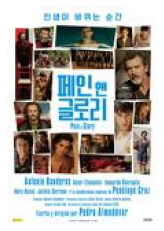

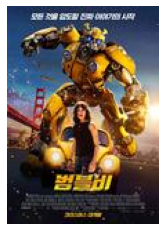

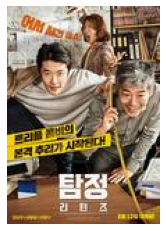

In [142]:
import requests
import json
import requests
from PIL import Image
from io import BytesIO

for i in final_dict:
    url = f'https://openapi.naver.com/v1/search/movie.json?display=100&query={i}'
    clientld="WR0zFM1GFTyg_qSIRhlX"
    clientSecret="Fhg_vv2FM1"
    header={
        "X-Naver-Client-id":clientld,
        "X-naver-Client-secret":clientSecret
    }

    r = requests.get(url, headers=header)
    load = json.loads(r.text)
#     print(load)

    url = load['items'][0]['image']
#     print(url)
    
    r = requests.get(url)
    img = Image.open(BytesIO(r.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()